<a href="https://colab.research.google.com/github/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/blob/main/PredictionComparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utility Code

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import os
import collections
import json
from google.colab import files

In [ ]:
!wget https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
!unzip P2_measurements.zip -d P2_measurements

--2021-11-23 17:34:59--  https://github.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/raw/main/Dataset/P2_measurements.zip
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/main/Dataset/P2_measurements.zip [following]
--2021-11-23 17:34:59--  https://raw.githubusercontent.com/olivieromassi/Hysteresis-Modelling-with-Neural-Networks/main/Dataset/P2_measurements.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9358428 (8.9M) [application/zip]
Saving to: ‘P2_measurements.zip’

P2_measurements.zip 100%[===================>]   8.92

In [ ]:
cwd = "/content/P2_measurements"

# Set the following flag to True to consider the whole Hysteresis Curve, including
# the first Magnetization curve.
include_first_magnetization = True

# The scaler is used to rescale the dataset values between -1 and 1
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Creating a dictionary containing all the measurements divided by frequency
dataset = {}
columns = ["t", "B", "H", "-H"] # t: timestamp, B: Magnetic Flux Density, H: Magnetic Field 

for file in os.listdir(cwd):
    temp_data = pd.read_csv(os.path.join(cwd, file),sep=';', header=None, names=columns)
    # Normalizing the Dataset 
    temp_data_norm = pd.DataFrame(scaler.fit_transform(temp_data[['H', 'B']]), columns=['H', 'B']) 
    if include_first_magnetization:
        dataset[file] = temp_data_norm
    else:
        # Select only the second half of the curve
        dataset[file] = temp_data_norm[int(len(temp_data)/2):].reset_index(drop=True)

dataset = collections.OrderedDict(sorted(dataset.items(), key=lambda t: t[1].shape, reverse=True))

In [ ]:
seq_len = 20

subsample_len = 200 

dataset_sub = {}

for freq in dataset:
    dataset_sub[freq] = dataset[freq].iloc[np.arange(0, len(dataset[freq]), int(len(dataset[freq])/subsample_len))]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def plot_prediction(prediction, ground_truth, input_signal, frequency):

    MSE = mean_squared_error(y_true=ground_truth, y_pred=prediction)
    MAE = mean_absolute_error(y_true=ground_truth, y_pred=prediction)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(frequency)

    ax1.set_title('Prediction')
    ax1.scatter(input_signal, prediction)
    ax1.grid(True)
    ax1.text(x=-1, y=0.9, s='MSE:' + str(round(MSE, 6)), fontsize=12)
    ax1.text(x=-1, y=0.75, s='MAE:' + str(round(MAE, 6)), fontsize=12)

    ax2.set_title('Ground Truth')
    ax2.scatter(input_signal, ground_truth, c='orange')
    ax2.grid(True)

# Predictions Comparisons:
The training has been performed over the entire Dataset, including the first magnetization curve. The sequence length, for comparison purposes is fixed to 20.

## First Model

dRNN with 256 units: 
*  Stateful Training
*  No Subsampling
*  Batches containing 11 sequences of 20 elements, one for each input frequency
*  The lower frequency curve is repeated once, the higher frequency curves are repeated to properly dimension the batches.
*  50 epochs, 20000 batches, $10^6$ gradient updates.

In [ ]:
# Read prediction file    
with open('/content/dRNN_256_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_False_repeated_True_num_epochs_50.h5_predictions.txt', 'r') as file:
     model_predictions = json.load(file)

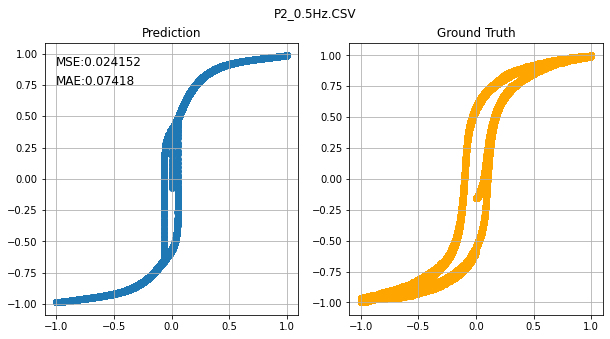

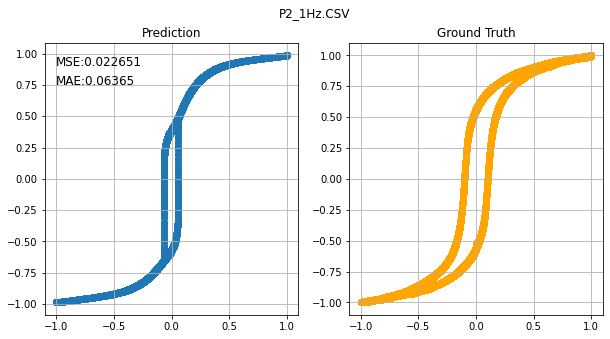

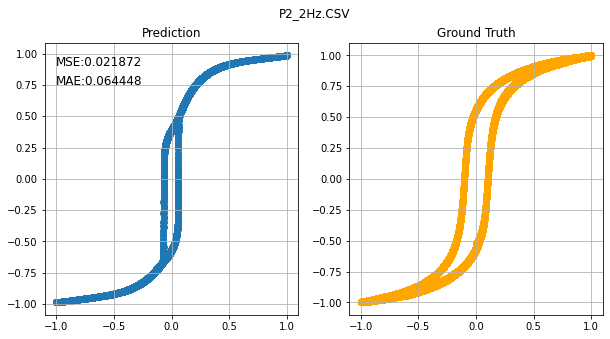

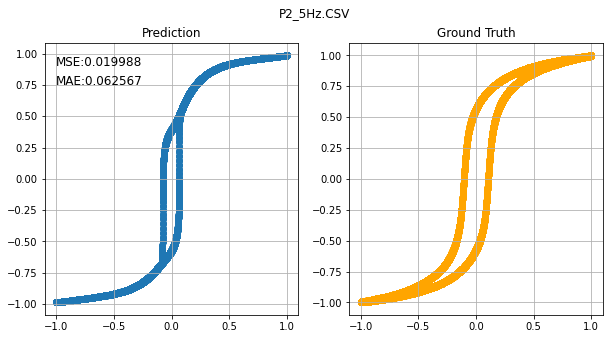

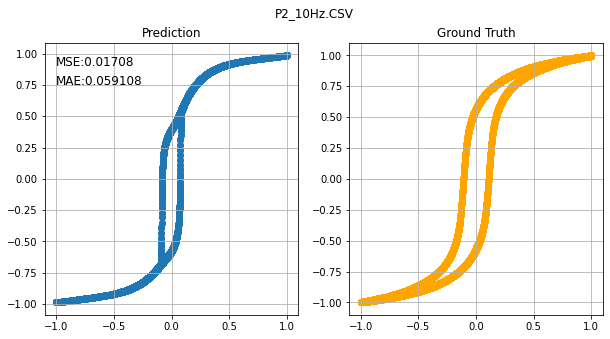

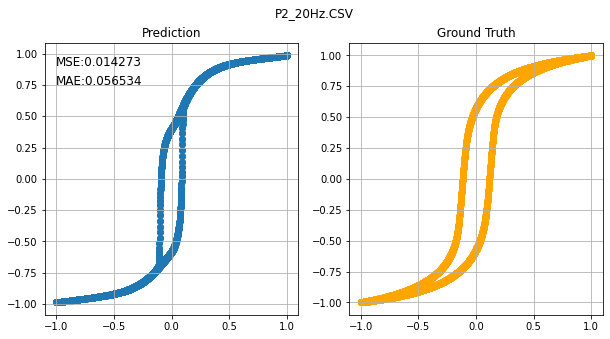

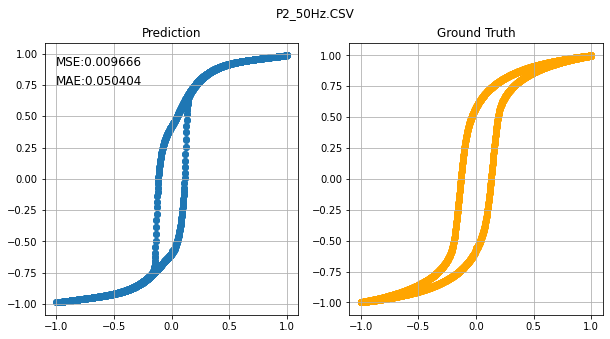

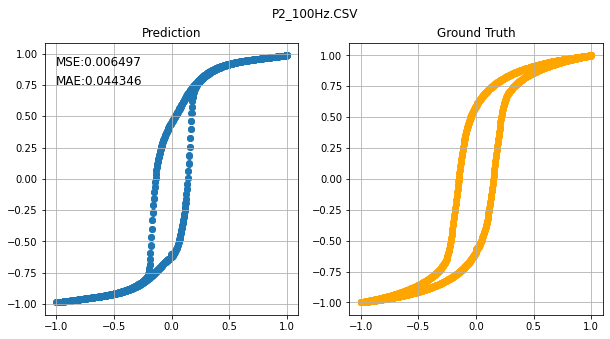

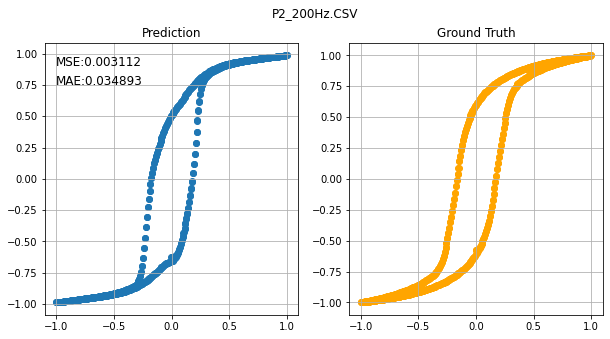

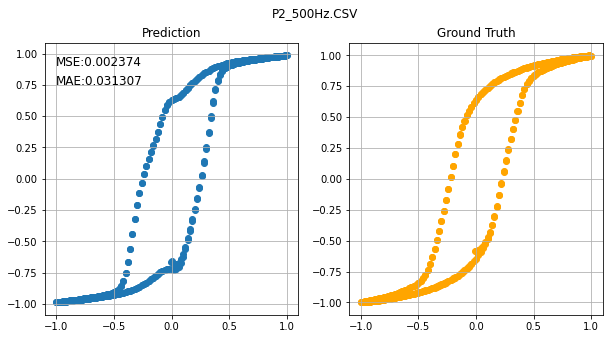

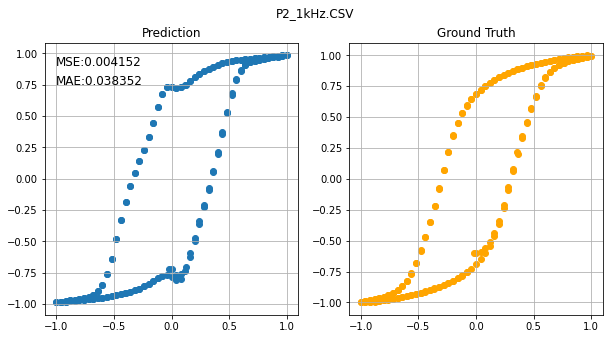

In [ ]:
# Testing the model on the training data itself, only to have an idea of what it is learning
y_pred = []

for freq in dataset:
    x_signal = np.array(dataset[freq][['H']])
    # Divide the signal in batches
    x = x_signal.reshape(-1, seq_len)

    # Reshape batch predictions into a single array
    y_pred = np.array(model_predictions[freq]).reshape(-1, 1)
    y_true = dataset[freq]['B']
    
    plot_prediction(y_pred, y_true, x_signal, freq)

## Second Model

dRNN with 256 units: 
*  Stateful Training
*  Subsampling the Dataset to 200 samples per each frequency
*  Batches containing 11 sequences of 20 elements, one for each input frequency
*  Each curve is represented in the batches its entirety once.
*  100000 epochs, 10 batches, $10^6$ gradient updates.

In [ ]:
# Read prediction file    
with open('/content/dRNN_256_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_True_repeated_False_epochs_100000.h5_predictions.txt', 'r') as file:
     model_predictions = json.load(file)

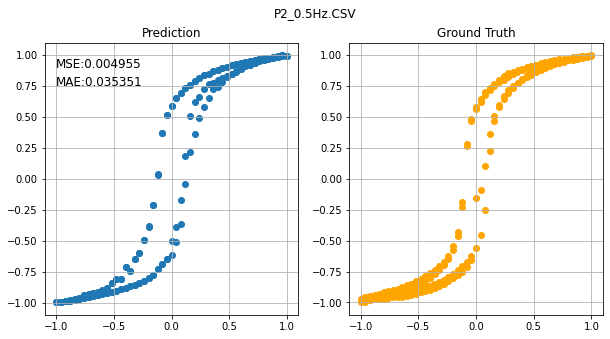

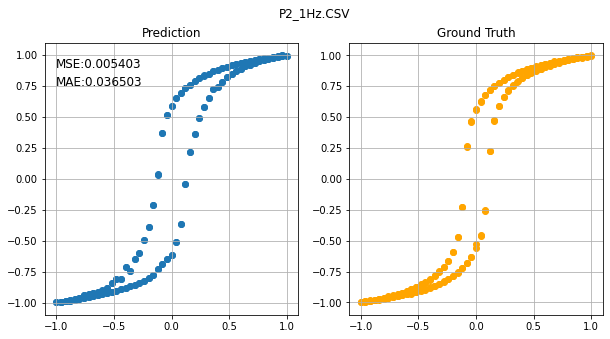

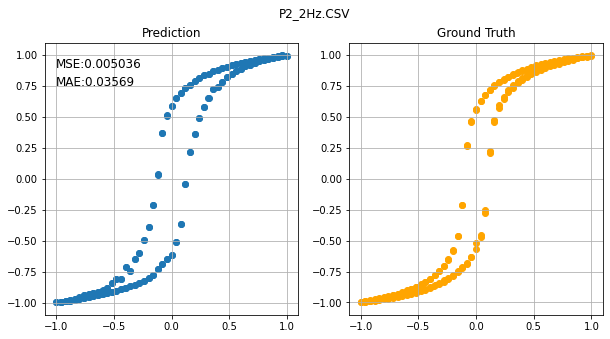

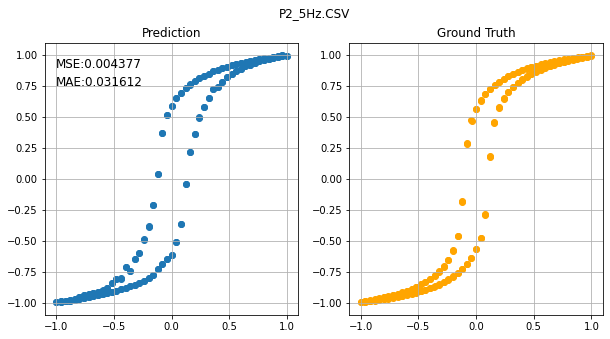

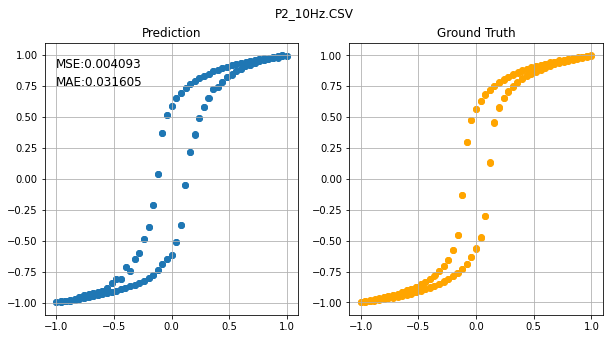

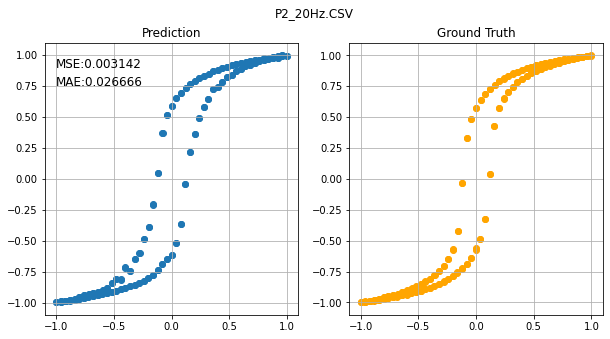

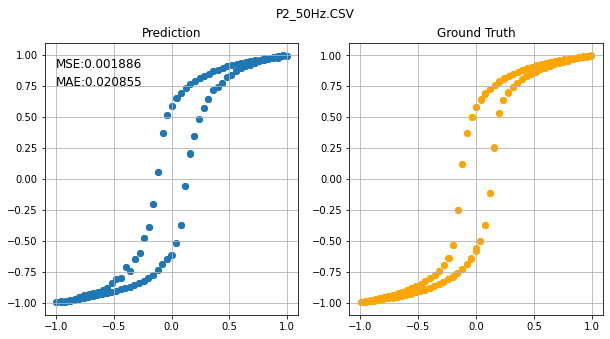

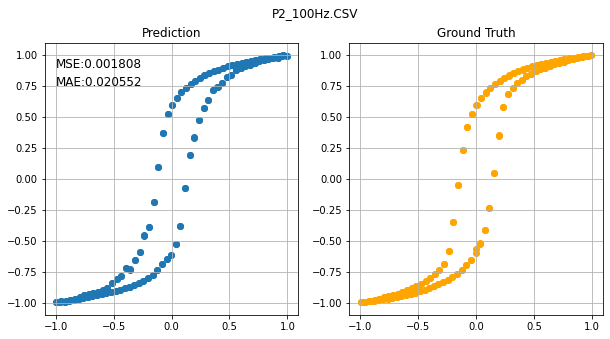

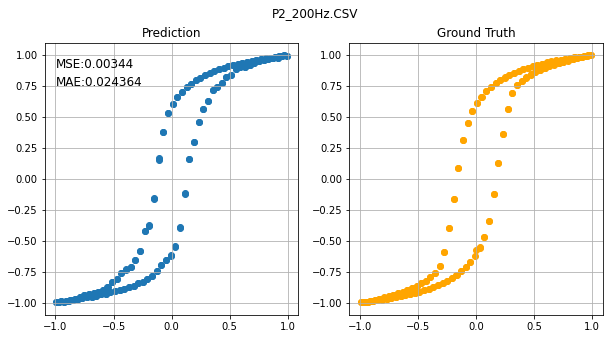

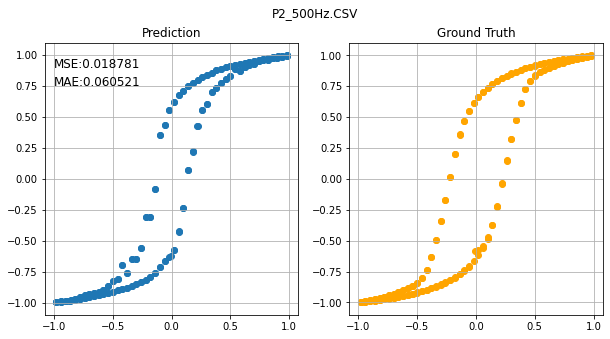

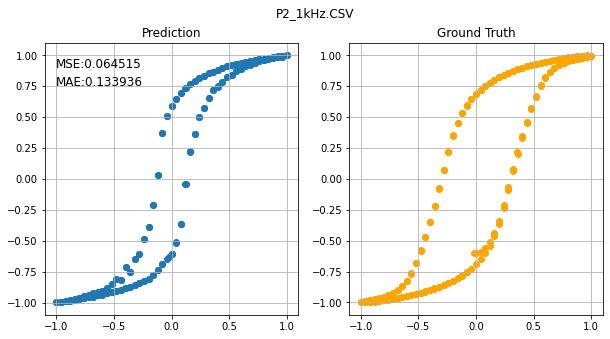

In [ ]:
# Testing the model on the training data itself, only to have an idea of what it is learning
y_pred = []

for freq in dataset:
    x_signal = np.array(dataset_sub[freq][['H']])
    # Divide the signal in batches
    x = x_signal.reshape(-1, seq_len)

    # Reshape batch predictions into a single array
    y_pred = np.array(model_predictions[freq]).reshape(-1, 1)
    y_true = dataset_sub[freq]['B']
    
    plot_prediction(y_pred, y_true, x_signal, freq)

## Third Model

dRNN with 256 units: 
*  Stateful Training
*  Subsampling the Dataset to 200 samples per each frequency
*  Batches containing 11 sequences of 20 elements, one for each input frequency
*  Each curve is represented once in its entirety, then the second period of each curve is repeated to fill 20000 batches.
*  50 epochs, 20000 batches, $10^6$ gradient updates.

In [ ]:
# Read prediction file    
with open('/content/dRNN_256_units_seq_len_20_stateful_True_first_magnetization_True_subsampling_True_repeated_True_epochs_50.h5_predictions.txt', 'r') as file:
     model_predictions = json.load(file)

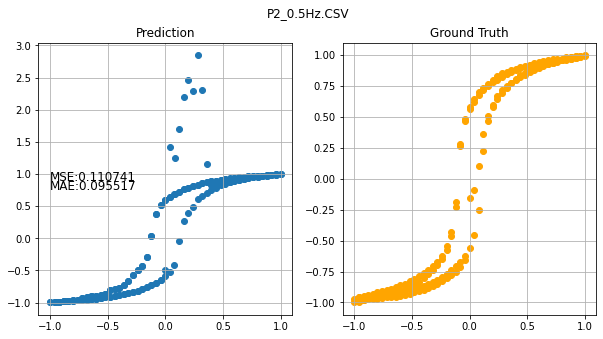

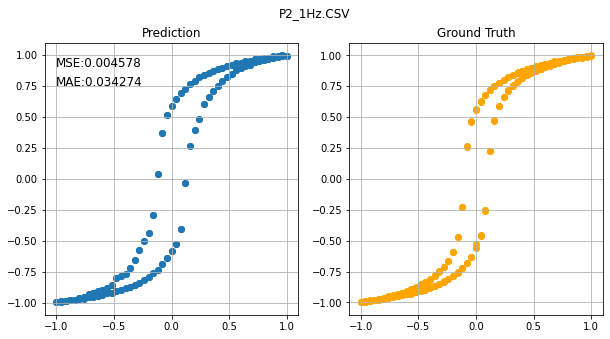

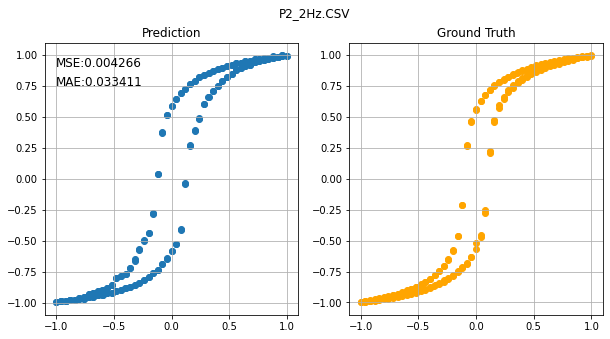

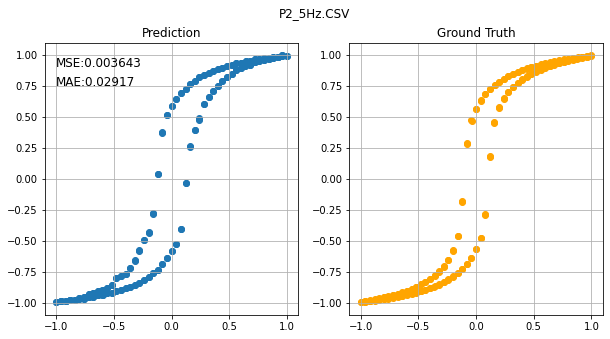

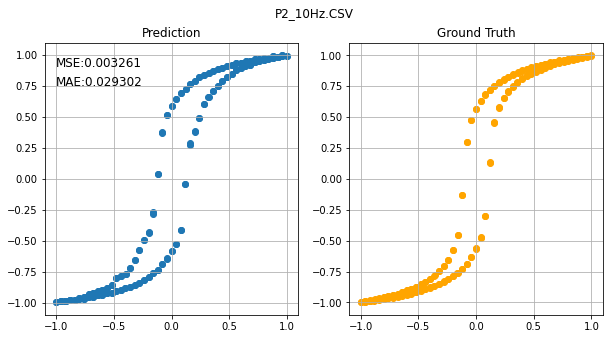

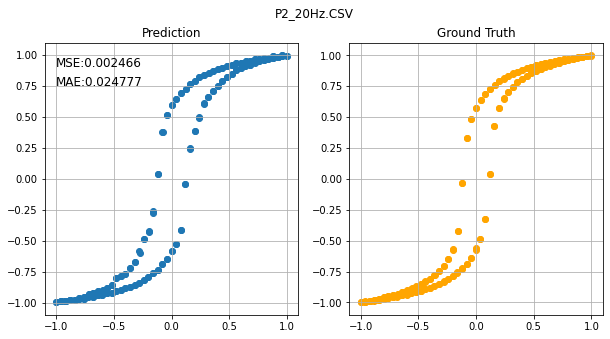

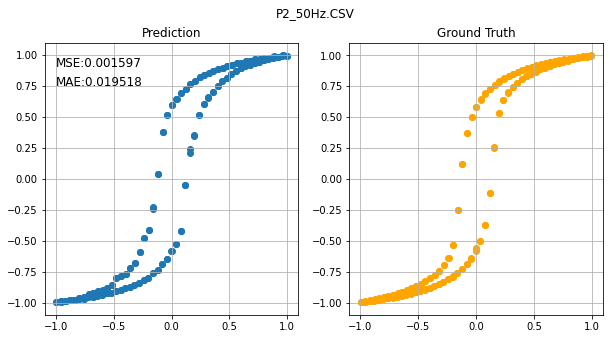

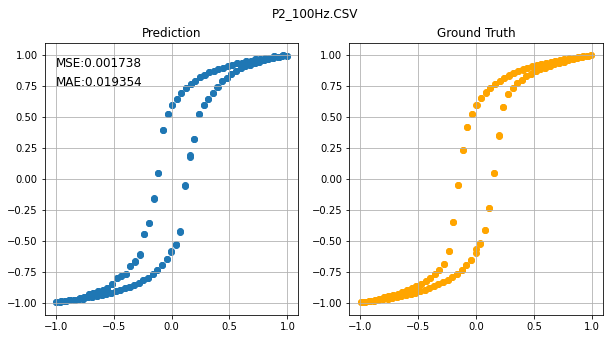

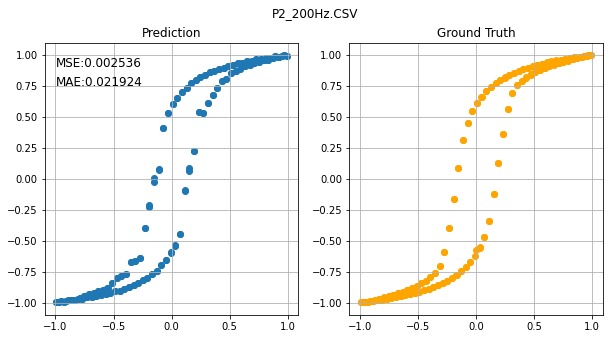

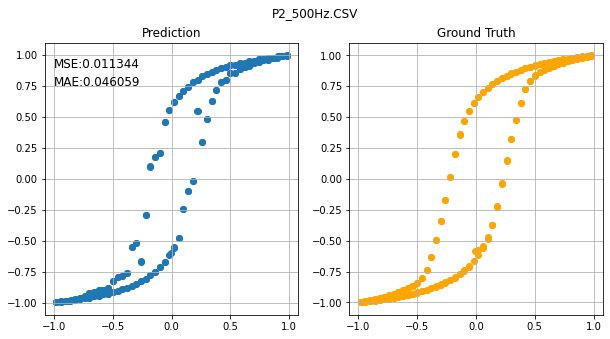

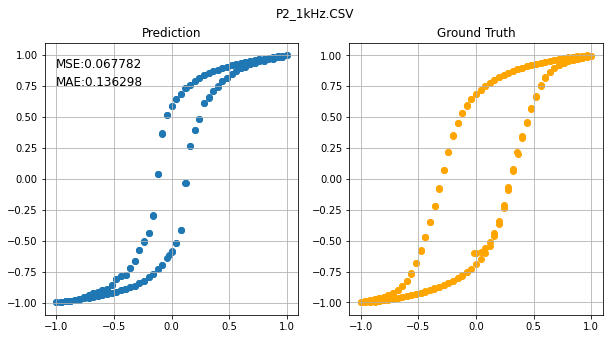

In [ ]:
# Testing the model on the training data itself, only to have an idea of what it is learning
y_pred = []

for freq in dataset:
    x_signal = np.array(dataset_sub[freq][['H']])
    # Divide the signal in batches
    x = x_signal.reshape(-1, seq_len)

    # Reshape batch predictions into a single array
    y_pred = np.array(model_predictions[freq]).reshape(-1, 1)
    y_true = dataset_sub[freq]['B']
    
    plot_prediction(y_pred, y_true, x_signal, freq)